In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from gensim.models import KeyedVectors
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import load_dataset
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string

E:\Anaconda\envs\GENSIM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if CUDA is available and get version info
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version: ", torch.version.cuda)
print("PyTorch Version: ", torch.__version__)

# Set the device to GPU if available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

CUDA Available:  True
CUDA Version:  12.1
PyTorch Version:  2.3.1
There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Laptop GPU


In [4]:
# Load the dataset
ds = load_dataset("dair-ai/emotion", "unsplit") # this is for unsplit dataset 416809 data

label_to_index = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4, 'surprise':5}
index_to_label = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

In [5]:
# Split the train test and validation
from sklearn.model_selection import train_test_split

# Convert the datasets to pandas DataFrames
ds_pd = ds['train'].to_pandas()

# Split into 80% train and 10% validation and 10% test
train_ds, _ds = train_test_split(ds_pd, test_size=0.2, random_state=42)
validation_ds, test_ds = train_test_split(_ds, test_size=0.5, random_state=42)

# Display basic information about the dataset
print(ds)
print(ds_pd)
# Load the training, validation, and test data into DataFrames
train_df = pd.DataFrame(train_ds)
validation_df = pd.DataFrame(validation_ds)
test_df = pd.DataFrame(test_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 416809
    })
})
                                                     text  label
0       i feel awful about it too because it s my job ...      0
1                                   im alone i feel awful      0
2       ive probably mentioned this before but i reall...      1
3                i was feeling a little low few days back      0
4       i beleive that i am much more sensitive to oth...      2
...                                                   ...    ...
416804  that was what i felt when i was finally accept...      1
416805  i take every day as it comes i m just focussin...      4
416806      i just suddenly feel that everything was fake      0
416807  im feeling more eager than ever to claw back w...      1
416808  i give you plenty of attention even when i fee...      0

[416809 rows x 2 columns]


label: fear
  word: i, frequency: 62321
  word: feel, frequency: 24803
  word: to, frequency: 22720
  word: and, frequency: 22207
  word: the, frequency: 18610
  word: a, frequency: 15185
  word: feeling, frequency: 14219
  word: of, frequency: 12493
  word: that, frequency: 10674
  word: my, frequency: 10105
  word: in, frequency: 7730
  word: it, frequency: 7539
  word: about, frequency: 6445
  word: was, frequency: 6384
  word: im, frequency: 6067
  word: but, frequency: 5957
  word: so, frequency: 5716
  word: me, frequency: 5629
  word: am, frequency: 5407
  word: like, frequency: 5046

label: sadness
  word: i, frequency: 158298
  word: feel, frequency: 67047
  word: and, frequency: 56309
  word: to, frequency: 48267
  word: the, frequency: 44725
  word: a, frequency: 34713
  word: feeling, frequency: 32697
  word: of, frequency: 27908
  word: that, frequency: 27639
  word: my, frequency: 25399
  word: in, frequency: 18730
  word: it, frequency: 18575
  word: like, frequency: 177

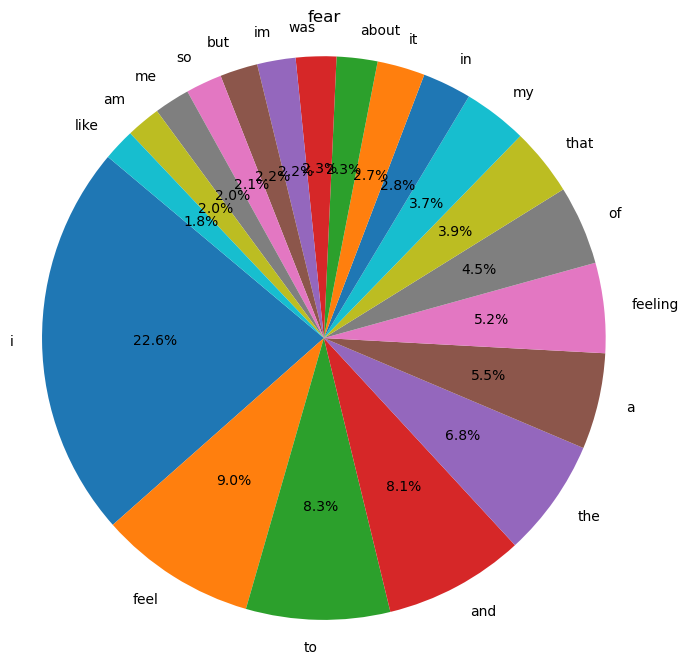

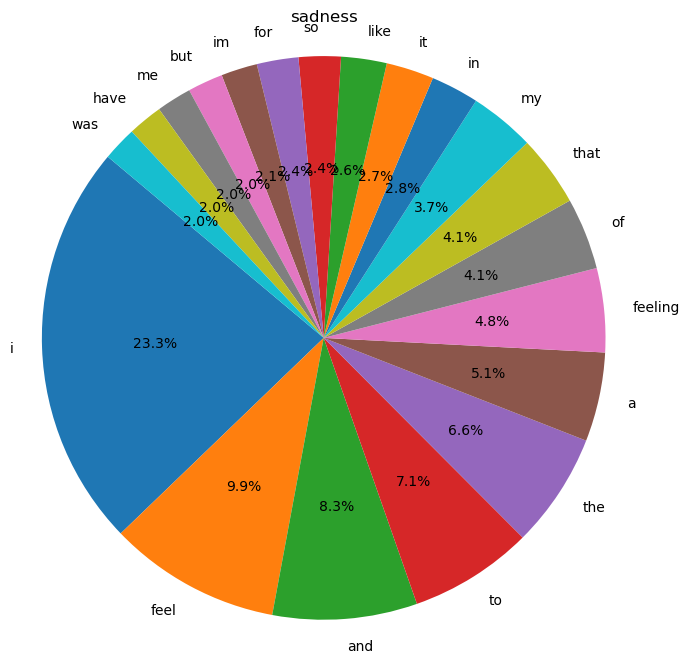

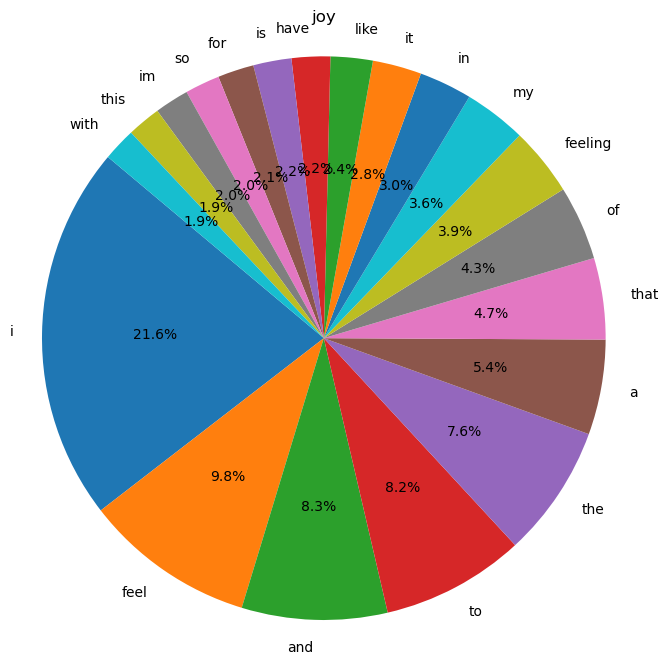

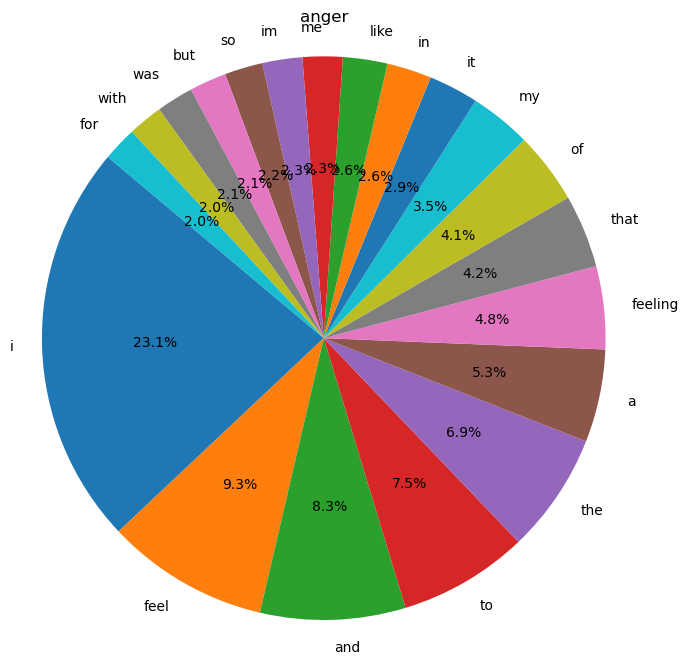

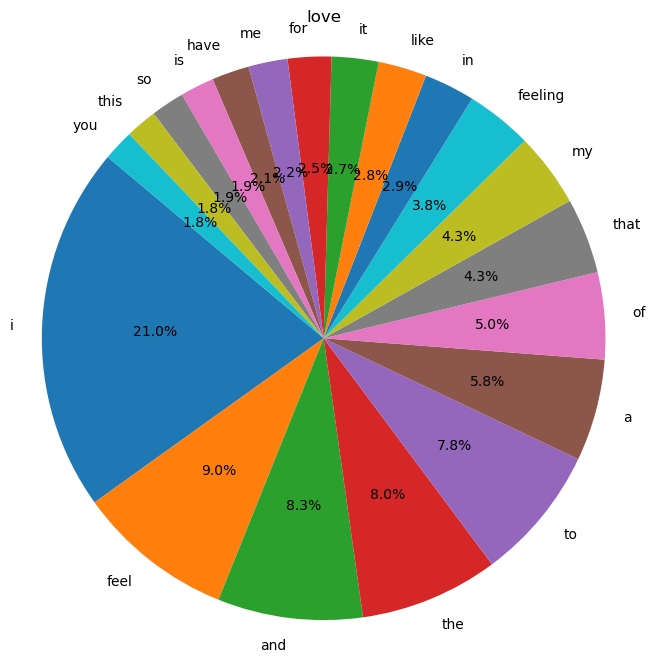

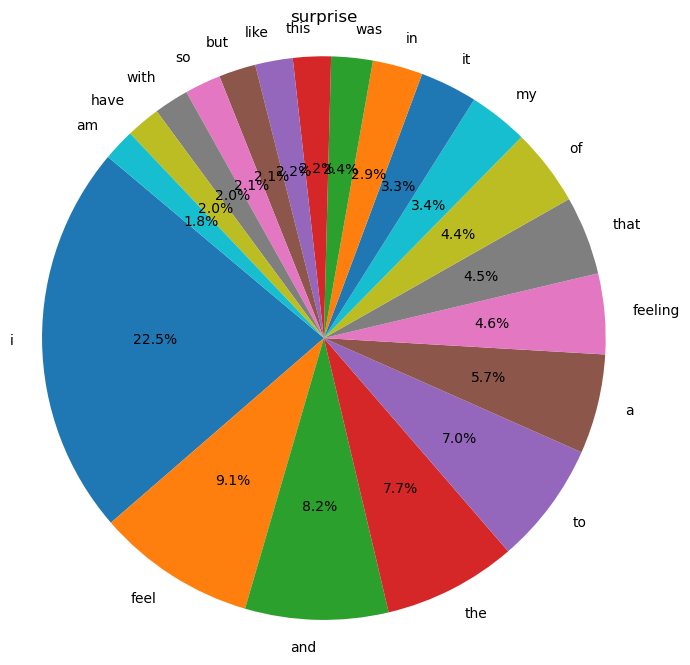

In [6]:
# Use a regular expression tokenizer
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    text = text.lower()
    words = tokenizer.tokenize(text)
    return words

def get_top_words(df, label_column, text_column, top_n=20):
    label_word_freq = {}
    for label in df[label_column].unique():
        label_texts = df[df[label_column] == label][text_column]
        all_words = []
        for text in label_texts:
            words = preprocess_text(text)
            all_words.extend(words)
        word_freq = Counter(all_words)
        top_words = word_freq.most_common(top_n)
        label_word_freq[label] = top_words
    return label_word_freq

# Calculate the words with the highest frequency of each sentiment label in the training set
top_words_per_label = get_top_words(train_df, 'label', 'text')

# Display the results
for label, top_words in top_words_per_label.items():
    print(f'label: {index_to_label[label]}')
    for word, freq in top_words:
        print(f'  word: {word}, frequency: {freq}')
    print()
    
def plot_top_words(label_word_freq):
    for label, top_words in label_word_freq.items():
        words, freqs = zip(*top_words)
        plt.figure(figsize=(8, 8))
        plt.pie(freqs, labels=words, autopct='%1.1f%%', startangle=140)
        plt.title(f'{index_to_label[label]}')
        plt.axis('equal')
        plt.show()

plot_top_words(top_words_per_label)

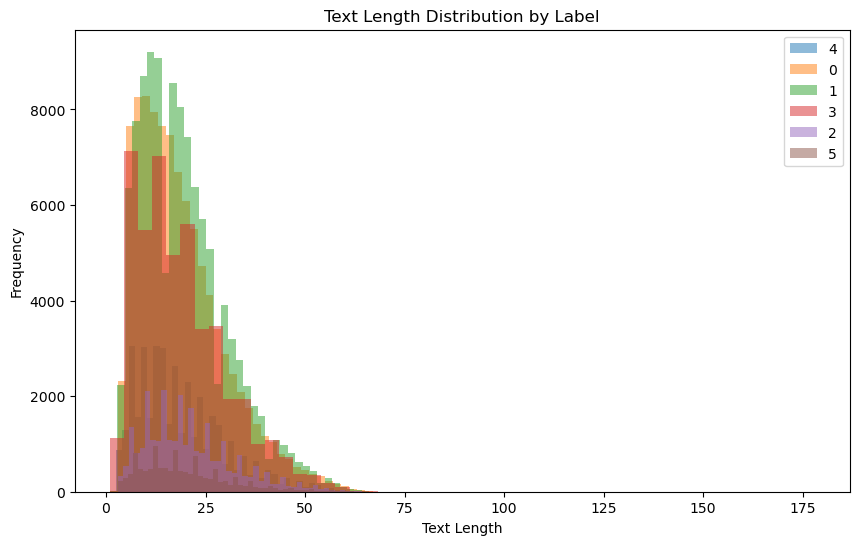

In [7]:
# Get unique labels
unique_labels = train_df['label'].unique()

plt.figure(figsize=(10, 6))

# For each unique label
for label in unique_labels:
    # Filter dataframe by label
    label_df = train_df[train_df['label'] == label]
    
    # Calculate text lengths
    text_lengths = [len(text.split()) for text in label_df['text']]
    
    # Plot histogram of text lengths
    plt.hist(text_lengths, bins=50, alpha=0.5, label=str(label))

plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [8]:
# Check for missing values in the dataset
print(train_df.isnull().sum())
print(validation_df.isnull().sum())
print(test_df.isnull().sum())

# Data Cleaning
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
# Load stop word list
stop_words = set(stopwords.words('english'))
# Add some words to the stop words list
custom_stop_words = {'im', 'ill', 'ive', 't'}
stop_words.update(custom_stop_words)
# Remove some words from the stop words list.
words_to_keep = {'not', 'didn', 'don'} #"but", "be"?
stop_words.difference_update(words_to_keep)

# Text cleaning and normalization function
def clean_text(text):
    # more can be added as needed

    print("Before cleaning:", text) # Print text before cleaning

    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    text = text.strip() # Remove extra spaces

    # Remove stop words
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    cleaned_text = ' '.join(cleaned_words)

    print("After cleaning:", cleaned_text) # Print text after cleaning
    print('\n')

    return cleaned_text  # Return the cleaned text with stopwords removed

# Apply text cleaning to the DataFrames
train_df['text'] = train_df['text'].apply(clean_text)
validation_df['text'] = validation_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



After cleaning: feel rage innocent people put death state name name justice


Before cleaning: im feeling tortured over here
After cleaning: feeling tortured


Before cleaning: im feeling restless and matt and i are nitpicking one another about who feeds abigail lunch the most and who gets the last few slices of leftover pie
After cleaning: feeling restless matt nitpicking one another feeds abigail lunch gets last slices leftover pie


Before cleaning: i feel like a jaded cat whatever who doesn t ever get nervous before races because i ve just done so many and i couldn t care less
After cleaning: feel like jaded cat whatever ever get nervous races done many care less


Before cleaning: i feel like a fake for the most part lately
After cleaning: feel like fake part lately


Before cleaning: i dont even know where to begin i feel stupid for going through this again and again im fucking sick of all this shit
After cleaning: dont even know begin feel stupid going fucking sick shit


Before

label: fear
  word: feel, frequency: 24803
  word: feeling, frequency: 14219
  word: like, frequency: 5046
  word: not, frequency: 4162
  word: little, frequency: 2855
  word: know, frequency: 2431
  word: really, frequency: 2248
  word: time, frequency: 1985
  word: still, frequency: 1970
  word: bit, frequency: 1916
  word: get, frequency: 1758
  word: people, frequency: 1705
  word: would, frequency: 1701
  word: think, frequency: 1617
  word: want, frequency: 1513
  word: scared, frequency: 1427
  word: afraid, frequency: 1421
  word: anxious, frequency: 1380
  word: going, frequency: 1368
  word: nervous, frequency: 1332

label: sadness
  word: feel, frequency: 67047
  word: feeling, frequency: 32697
  word: like, frequency: 17751
  word: not, frequency: 10895
  word: really, frequency: 5988
  word: know, frequency: 5750
  word: time, frequency: 4857
  word: little, frequency: 4539
  word: get, frequency: 4351
  word: would, frequency: 3982
  word: people, frequency: 3806
  word: 

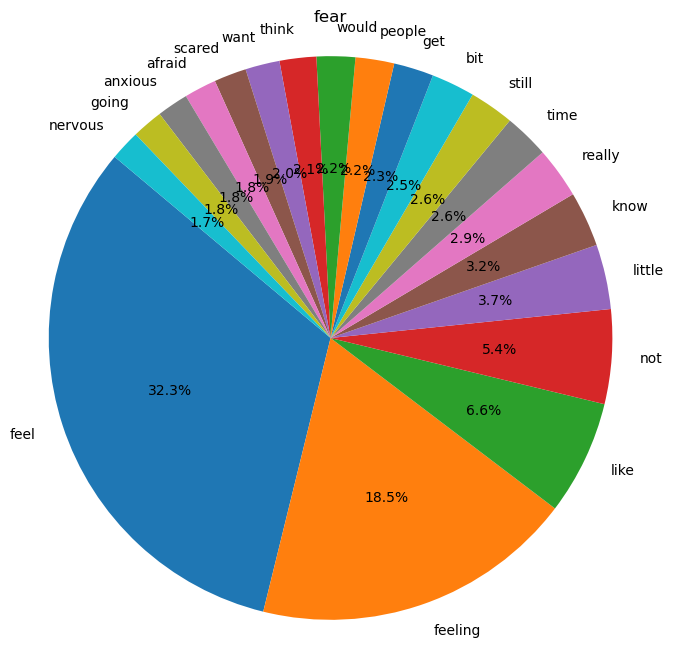

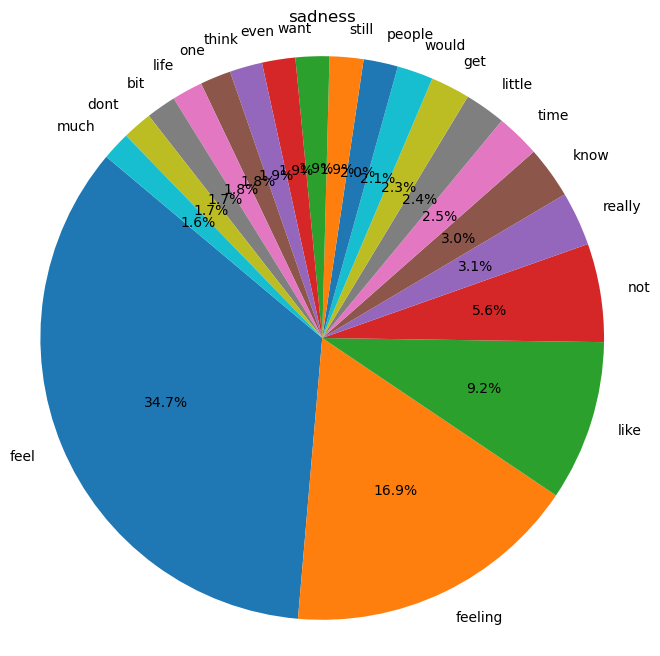

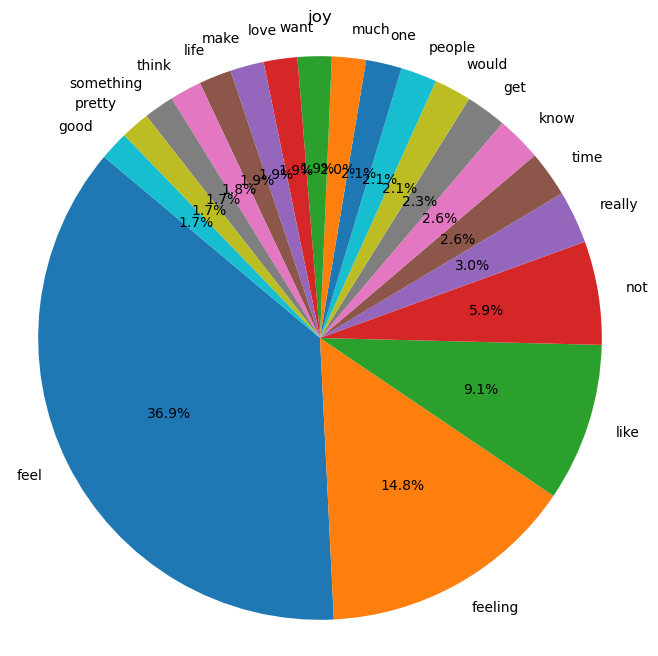

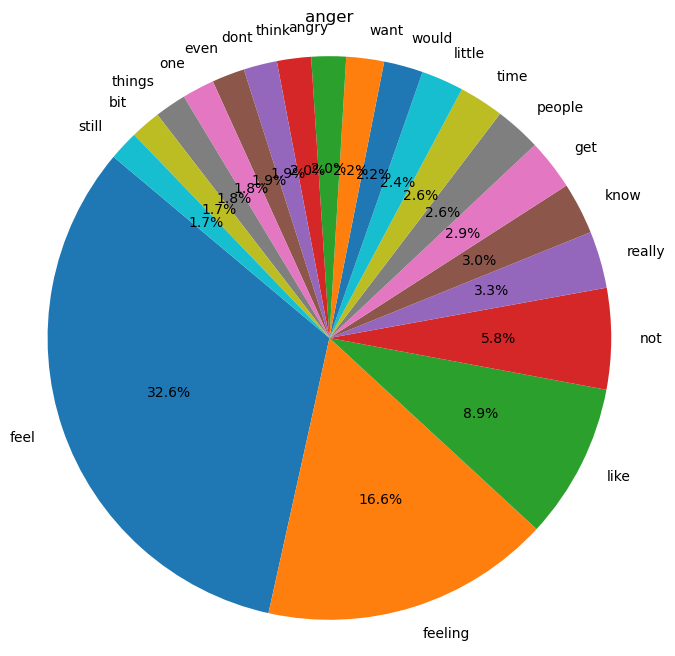

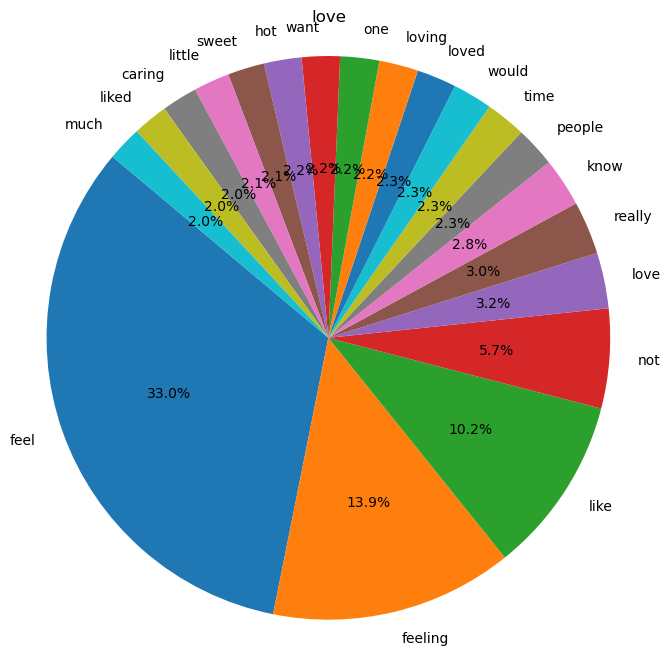

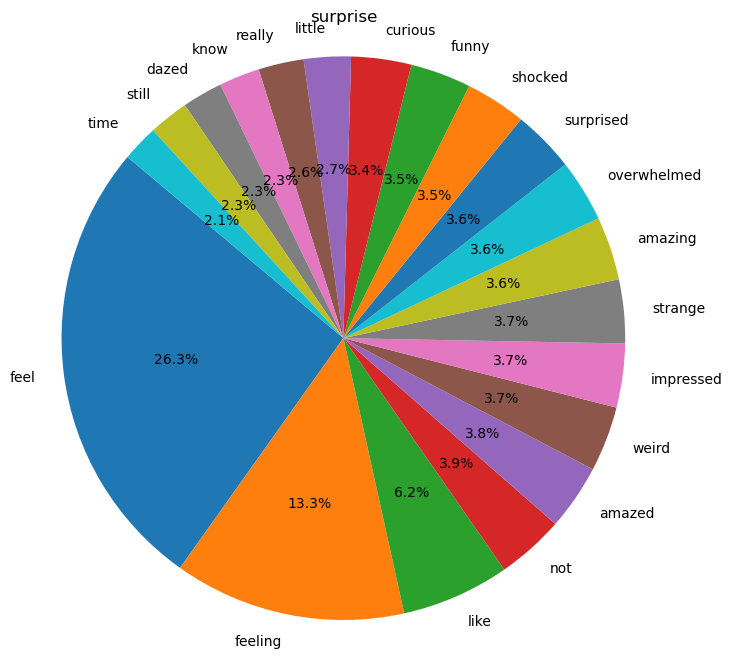

In [9]:
# Calculate the words with the highest frequency of each sentiment label in the training set
top_words_per_label = get_top_words(train_df, 'label', 'text')

# Display the results
for label, top_words in top_words_per_label.items():
    print(f'label: {index_to_label[label]}')
    for word, freq in top_words:
        print(f'  word: {word}, frequency: {freq}')
    print()

plot_top_words(top_words_per_label)

In [10]:
# Use the str.contains() method to find sentences that contain 'feel|feels|feeling|felt'
contains_feel = train_df['text'].str.contains(r'\bfeel\b|\bfeels\b|\bfeeling\b|\bfelt\b', regex=True)

# Calculate the number of sentences that contain ‘feel|feels|feeling|felt’
num_feel_sentences = contains_feel.sum()

print(f"'feel|feels|feeling|felt' appears in {num_feel_sentences} out of {len(train_df['text'])} sentences.")

'feel|feels|feeling|felt' appears in 324511 out of 333447 sentences.


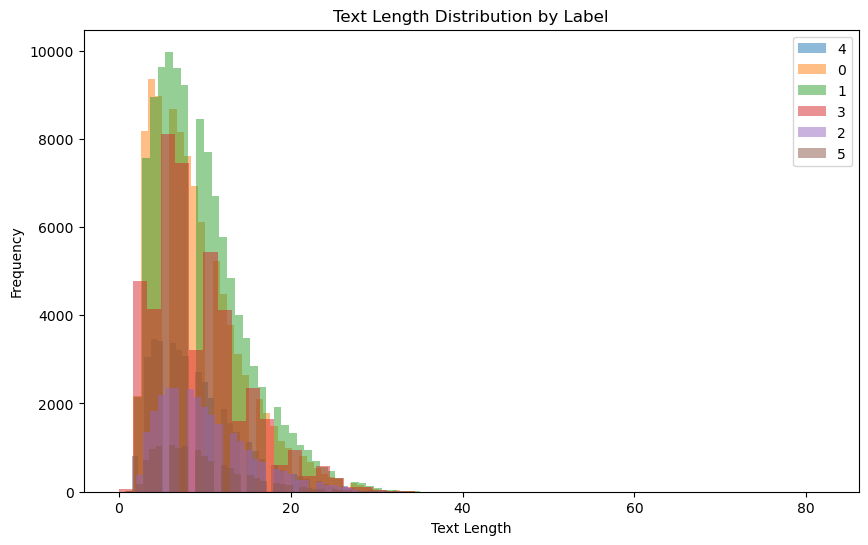

In [11]:
# Get unique labels
unique_labels = train_df['label'].unique()

plt.figure(figsize=(10, 6))

# For each unique label
for label in unique_labels:
    # Filter dataframe by label
    label_df = train_df[train_df['label'] == label]
    
    # Calculate text lengths
    text_lengths = [len(text.split()) for text in label_df['text']]
    
    # Plot histogram of text lengths
    plt.hist(text_lengths, bins=50, alpha=0.5, label=str(label))

plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

int64 int64 int64
[4 0 1 3 2 5] [3 1 0 4 2 5] [1 0 3 2 4 5]
                                                     text    label
146122  sharing weve done learned making decisions bes...     fear
334806  sit quietly trying get work done feeling large...  sadness
182273                                         feel jolly      joy
198898    like keep desk middle day pick feeling stressed    anger
80779                                feel witness sincere      joy


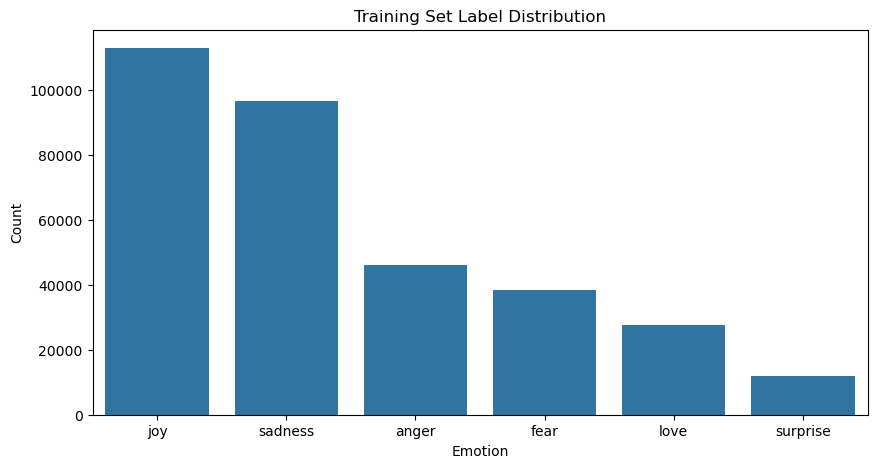

fear 38336
sadness 96683
joy 112820
anger 45978
love 27701
surprise 11929


In [12]:
# Visualize the distribution of emotion labels
import seaborn as sns

# Get the label names
label_names = ds['train'].features['label'].names

# Map numeric labels to actual emotion labels
train_df_forplot = train_df.copy()  # Create a deep copy
train_df_forplot['label'] = train_df['label'].apply(lambda x: label_names[x])

# Verify all labels are integers
print(train_df['label'].dtype, validation_df['label'].dtype, test_df['label'].dtype)
print(train_df['label'].unique(), validation_df['label'].unique(), test_df['label'].unique())

print(train_df_forplot.head())

# Plot the distribution of emotion labels in the training set
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df_forplot, x='label', order=train_df_forplot['label'].value_counts().index)
plt.title('Training Set Label Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

train_df_dic = {}
for index, row in train_df_forplot.iterrows():
    label = row['label']
    text = row['text']

    if label in train_df_dic:
        train_df_dic[label].append(text)
    else:
        train_df_dic[label] = [text]

for key, value in train_df_dic.items():
    print(key, len(value))

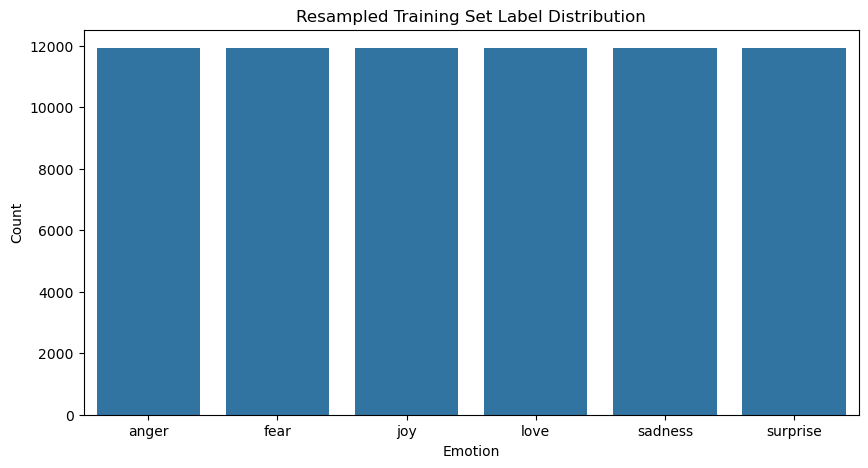

anger 11929
fear 11929
joy 11929
love 11929
sadness 11929
surprise 11929
int64 int64 int64
[3 4 1 2 0 5] [3 1 0 4 2 5] [1 0 3 2 4 5]


In [13]:
# This is an undersamper method to make the number of train samples consistent, but it will result in a large reduction in the number of samples

from imblearn.under_sampling import RandomUnderSampler

# Initialize the undersampler
rus = RandomUnderSampler(random_state=42)

# Convert the data into a format suitable for RandomUnderSampler
X = []
y = []
for label, texts in train_df_dic.items():
    if len(texts) == 0:  # Skip empty categories
        continue
    for text in texts:
        X.append(text)
        y.append(label)

X = np.array(X).reshape(-1, 1)
y = np.array(y)

# Perform undersampling on the data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Update the dictionary
resampled_dic = {}
for i in range(len(X_resampled)):
    label = y_resampled[i]
    text = X_resampled[i][0]

    if label in resampled_dic:
        resampled_dic[label].append(text)
    else:
        resampled_dic[label] = [text]

# Convert resampled_dic to a DataFrame
resampled_df = pd.DataFrame([(k, v) for k, vs in resampled_dic.items() for v in vs], columns=['label', 'text'])

# Plot the distribution of emotion labels in the resampled data
plt.figure(figsize=(10, 5))
sns.countplot(data=resampled_df, x='label', order=resampled_df['label'].value_counts().index)
plt.title('Resampled Training Set Label Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Print the updated dictionary
for key, value in resampled_dic.items():
    print(key, len(value))

# Create a mapping from label to index
# label_to_index = {label: idx for idx, label in enumerate(train_df_forplot['label'].unique())} wrong
label_to_index = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4, 'surprise':5}

# Convert 'label' column to int
resampled_df['label'] = resampled_df['label'].map(label_to_index).astype(int)

# Update train_df
train_df = resampled_df

# Convert all labels to int64
train_df['label'] = train_df['label'].astype(np.int64)
validation_df['label'] = validation_df['label'].astype(np.int64)
test_df['label'] = test_df['label'].astype(np.int64) 

# Check unique labels
print(train_df['label'].dtype, validation_df['label'].dtype, test_df['label'].dtype)
print(train_df['label'].unique(), validation_df['label'].unique(), test_df['label'].unique())

In [14]:
# Use undersamper method to make the number of test samples consistent

test_df['label'] = test_df['label'].apply(lambda x: label_names[x])

test_df_dic = {}
for index, row in test_df.iterrows():
    label = row['label']
    text = row['text']

    if label in test_df_dic:
        test_df_dic[label].append(text)
    else:
        test_df_dic[label] = [text]

for key, value in test_df_dic.items():
    print(key, len(value))

# Convert the data into a format suitable for RandomUnderSampler
X = []
y = []
for label, texts in test_df_dic.items():
    if len(texts) == 0:  # Skip empty categories
        continue
    for text in texts:
        X.append(text)
        y.append(label)

X = np.array(X).reshape(-1, 1)
y = np.array(y)

# Perform undersampling on the data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Update the dictionary
resampled_dic = {}
for i in range(len(X_resampled)):
    label = y_resampled[i]
    text = X_resampled[i][0]

    if label in resampled_dic:
        resampled_dic[label].append(text)
    else:
        resampled_dic[label] = [text]

# Print the updated dictionary
for key, value in resampled_dic.items():
    print(key, len(value))

# Convert resampled_dic to a DataFrame
resampled_df = pd.DataFrame([(k, v) for k, vs in resampled_dic.items() for v in vs], columns=['label', 'text'])

label_to_index = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4, 'surprise':5}

# Convert 'label' column to int
resampled_df['label'] = resampled_df['label'].map(label_to_index).astype(int)

# Randomly shuffle the DataFrame
resampled_df = resampled_df.sample(frac=1, random_state=42)

# Update test_df
test_df = resampled_df

# Convert test_df labels to int64
test_df['label'] = test_df['label'].astype(np.int64)

# # Check unique labels
# print(train_df['label'].dtype, validation_df['label'].dtype, test_df['label'].dtype)
# print(train_df['label'].unique(), validation_df['label'].unique(), test_df['label'].unique())

# print(test_df)

# Count the number of each label
label_counts = resampled_df['label'].value_counts()

# Print the counts
print(label_counts)

joy 14263
sadness 12197
anger 5681
love 3413
fear 4601
surprise 1526
anger 1526
fear 1526
joy 1526
love 1526
sadness 1526
surprise 1526
label
3    1526
2    1526
4    1526
1    1526
0    1526
5    1526
Name: count, dtype: int64


Top 10 words similar to 'happy':
glad: 0.7408890724182129
pleased: 0.6632170677185059
ecstatic: 0.6626912951469421
overjoyed: 0.6599285006523132
thrilled: 0.6514049172401428
satisfied: 0.6437950134277344
proud: 0.6360421180725098
delighted: 0.627237856388092
disappointed: 0.6269948482513428
excited: 0.6247665882110596
Vector for 'happy':
[-5.18798828e-04  1.60156250e-01  1.60980225e-03  2.53906250e-02
  9.91210938e-02 -8.59375000e-02  3.24218750e-01 -2.17285156e-02
  1.34765625e-01  1.10351562e-01 -1.04980469e-01 -2.90527344e-02
 -2.38037109e-02 -4.02832031e-02 -3.68652344e-02  2.32421875e-01
  3.20312500e-01  1.01074219e-01  5.83496094e-02 -2.91824341e-04
 -3.29589844e-02  2.11914062e-01  4.32128906e-02 -8.59375000e-02
  2.81250000e-01 -1.78222656e-02  3.79943848e-03 -1.71875000e-01
  2.06054688e-01 -1.85546875e-01  3.73535156e-02 -1.21459961e-02
  2.04101562e-01 -3.80859375e-02  3.61328125e-02 -8.15429688e-02
  8.44726562e-02  9.37500000e-02  1.44531250e-01  7.42187500e-02
  2.519531

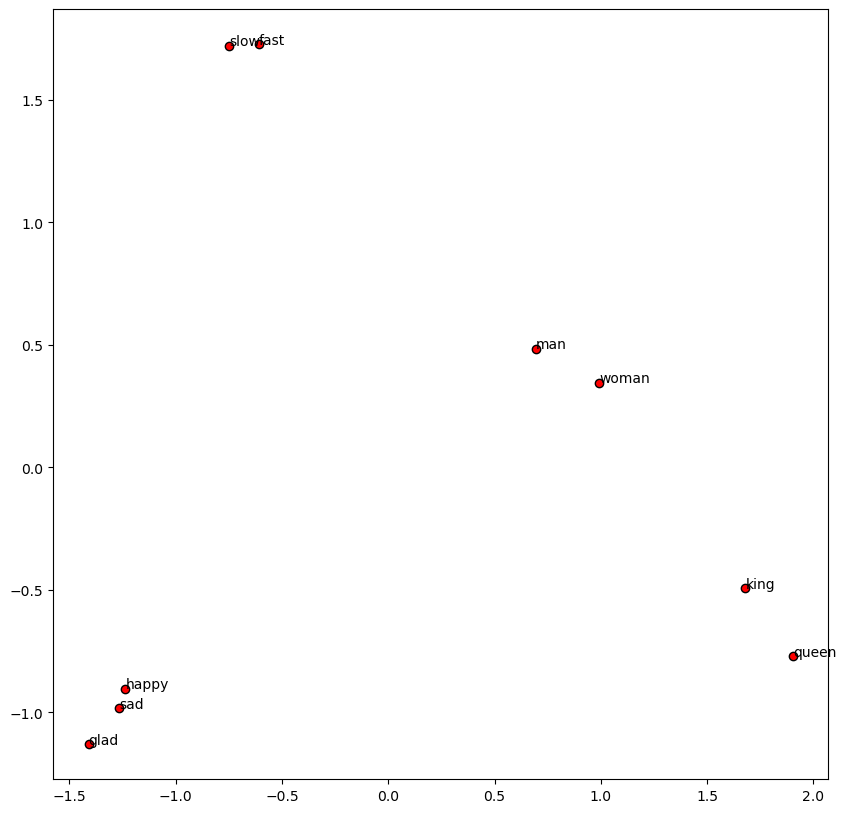

In [15]:
# Load the Word2Vec embeddings
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
embedding_dim = 300  # Word2Vec embeddings are 300-dimensional


# Check if Word2Vec embeddings work
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def find_most_similar(word, topn=10):
    if word in word2vec:
        print(f"Top {topn} words similar to '{word}':")
        for similar_word, similarity in word2vec.most_similar(word, topn=topn):
            print(f"{similar_word}: {similarity}")
    else:
        print(f"'{word}' not in vocabulary!")

find_most_similar('happy', topn=10)

word = "happy"
if word in word2vec:
    vector = word2vec[word]
    print(f"Vector for '{word}':\n{vector}")
else:
    print(f"'{word}' not in vocabulary!")

def visualize_embeddings(word2vec, words):
    # Get vectors for words
    word_vectors = [word2vec[word] for word in words]

    # Use PCA to reduce word vectors to 2 dimensions
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(word_vectors)

    # Plot word vectors
    plt.figure(figsize=(10, 10))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, principal_components):
        plt.text(x, y, word)
    plt.show()

# Example usage
words = ['king', 'queen', 'man', 'woman', 'happy', 'sad', 'fast', 'slow', 'glad']
visualize_embeddings(word2vec, words)


In [16]:
# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, df, word2vec, max_length=35):#50
        self.texts = df['text'].values
        self.labels = df['label'].values
        self.word2vec = word2vec
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text
        tokens = text.split()
        # Pad or truncate tokens
        tokens = tokens[:self.max_length] + ['<PAD>'] * (self.max_length - len(tokens))

        # Convert tokens to word vectors
        vectors = []
        for token in tokens:
            if token in self.word2vec:
                vectors.append(self.word2vec[token])
            else:
                vectors.append(np.zeros(embedding_dim))

        return torch.tensor(vectors, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_dataset = EmotionDataset(train_df, word2vec)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = EmotionDataset(validation_df, word2vec)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataset = EmotionDataset(test_df, word2vec)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = self.dropout(hidden[-1])
        out = self.fc(hidden)
        return out

# Hyperparameters
hidden_dim = 128
output_dim = len(train_df['label'].unique())
num_layers = 2
dropout = 0.1
learning_rate = 0.01
num_epochs = 10 #12,13? 

# Initialize model, loss function, and optimizer
model = LSTMModel(embedding_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 1119/1119 [01:41<00:00, 11.08it/s]


Epoch 1/10, Train Loss: 1.7931840385679052, Train Accuracy: 0.1679939642887082, Validation Loss: 1.8058758001386022, Validation Accuracy: 0.13548139440032628


100%|██████████| 1119/1119 [01:41<00:00, 11.07it/s]


Epoch 2/10, Train Loss: 1.7968120997883146, Train Accuracy: 0.16616369072568252, Validation Loss: 1.802896231047215, Validation Accuracy: 0.1145605911566421


100%|██████████| 1119/1119 [01:40<00:00, 11.10it/s]


Epoch 3/10, Train Loss: 1.7499527522130562, Train Accuracy: 0.18793137172716348, Validation Loss: 1.427671734906413, Validation Accuracy: 0.34747246947050214


100%|██████████| 1119/1119 [01:40<00:00, 11.10it/s]


Epoch 4/10, Train Loss: 1.0845066918071835, Train Accuracy: 0.4890043870679297, Validation Loss: 0.8050373945316655, Validation Accuracy: 0.5074734291403757


100%|██████████| 1119/1119 [01:40<00:00, 11.12it/s]


Epoch 5/10, Train Loss: 0.6417153501638458, Train Accuracy: 0.7377259898845949, Validation Loss: 0.5334865853099003, Validation Accuracy: 0.821213502555121


100%|██████████| 1119/1119 [01:41<00:00, 11.07it/s]


Epoch 6/10, Train Loss: 0.37118185543262927, Train Accuracy: 0.8973789364853159, Validation Loss: 0.3296652364378875, Validation Accuracy: 0.894268371680142


100%|██████████| 1119/1119 [01:40<00:00, 11.15it/s]


Epoch 7/10, Train Loss: 0.2904711015009795, Train Accuracy: 0.9168692541984519, Validation Loss: 0.28925986706273504, Validation Accuracy: 0.9083035435810081


100%|██████████| 1119/1119 [01:41<00:00, 11.08it/s]


Epoch 8/10, Train Loss: 0.26302002967602445, Train Accuracy: 0.9250426132394445, Validation Loss: 0.25842374062131335, Validation Accuracy: 0.9120462560879057


100%|██████████| 1119/1119 [01:41<00:00, 11.02it/s]


Epoch 9/10, Train Loss: 0.23443707533453703, Train Accuracy: 0.9310084667616731, Validation Loss: 0.26593577287279846, Validation Accuracy: 0.9125500827715266


100%|██████████| 1119/1119 [01:41<00:00, 11.07it/s]


Epoch 10/10, Train Loss: 0.2279983515068023, Train Accuracy: 0.9322100203984687, Validation Loss: 0.23344213517519868, Validation Accuracy: 0.9198675655574482


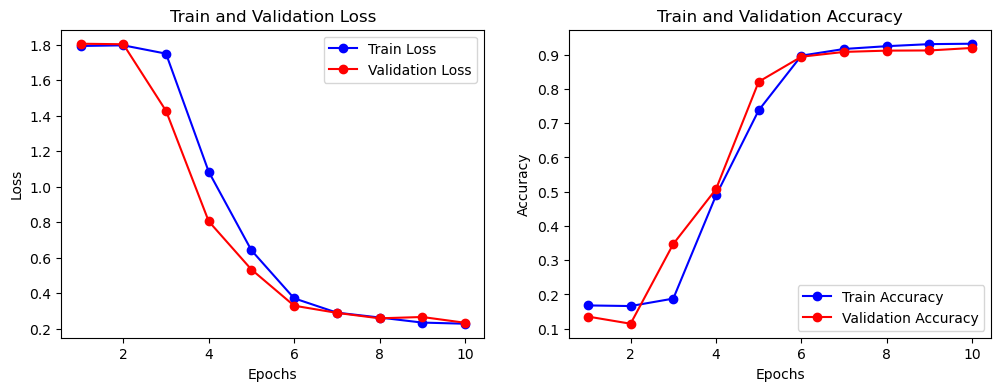

In [20]:
# NORMAL LSTM
# Training the model( you can skip this part to save your time, I have trained and saved the model.)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_corrects = 0
    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        epoch_train_corrects += torch.sum(preds == labels.data)

    epoch_train_loss /= len(train_loader)
    epoch_train_accuracy = epoch_train_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy.item())

    model.eval()
    epoch_val_loss = 0
    epoch_val_corrects = 0
    with torch.no_grad():
        for texts, labels in validation_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            epoch_val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss /= len(validation_loader)
    epoch_val_accuracy = epoch_val_corrects.double() / len(validation_loader.dataset)
    validation_losses.append(epoch_val_loss)
    validation_accuracies.append(epoch_val_accuracy.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

# Plot the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, validation_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the model
model_path = 'LSTM_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

/var/folders/4k/y7600sc50jl4vhfsy6hpmpgc0000gn/T/ipykernel_3643/1701873831.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(vectors, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Test Set Performance:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1526
           1       0.99      0.90      0.95      1526
           2       0.93      0.99      0.96      1526
           3       0.93      0.96      0.94      1526
           4       0.94      0.89      0.92      1526
           5       0.92      1.00      0.96      1526

    accuracy                           0.95      9156
   macro avg       0.95      0.95      0.95      9156
weighted avg       0.95      0.95      0.95      9156

Confusion Matrix: 
 [[1441    1    1   51   31    1]
 [   3 1380  120   10    1   12]
 [   1    6 1514    1    0    4]
 [   4    1    0 1469   51    1]
 [   3    3    0   50 1361  109]
 [   0    0    0    2    0 1524]]


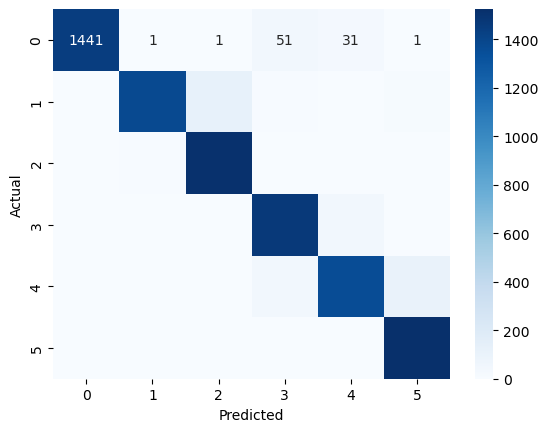

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model_path = 'LSTM_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Evaluate the model on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(output_dim)])
print("Test Set Performance:")
print(report)

# Print Confusion Matrix
conf = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix: \n",conf)

# Plot confusion matrix as a graph
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

note: {0:sadness, 1:joy, 2:love, 3:anger, 4:fear, 5:surprise}

Overall Performance:

Accuracy: The overall accuracy of the model is 95%, meaning 8698 out of 9156 test samples were correctly classified.

Macro Average: The average precision, recall, and F1-score across all labels are 95%, 95%, and 95% respectively. Macro average treats all classes equally and is suitable for imbalanced datasets.

Weighted Average: The weighted average of precision, recall, and F1-score across all labels are 95%, 95%, and 95% respectively. Weighted average takes into account the support of each label, providing a better reflection of the overall performance.

Overall, the model performs well on all the emotion labels. 

In [24]:
# use the model to predict some sentences
import contextlib
import io

def predict_emotion(Text):

    # Temporarily redirect stdout to suppress print statements
    with io.StringIO() as buf, contextlib.redirect_stdout(buf):
        text = clean_text(Text)
    
    # Preprocess the text
    tokens = text.split()
    tokens = tokens[:35] + ['<PAD>'] * (35 - len(tokens))
    vectors = []
    for token in tokens:
        if token in word2vec:
            vectors.append(word2vec[token])
        else:
            vectors.append(np.zeros(embedding_dim))
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor([vectors], dtype=torch.float32).to(device)
    
    # Make prediction
    outputs = model(input_tensor)
    _, preds = torch.max(outputs, 1)
    
    # Create a dictionary to map numeric labels to emotions
    label_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    
    # Convert numeric label to emotion
    predicted_emotion = label_to_emotion[preds.item()]
    
    # Print prediction
    print(f"The predicted emotion is: {predicted_emotion}")

print('input: I am happy.')
predict_emotion("I am happy.")
print('input: I feel happy.')
predict_emotion("I feel happy.")
print('input: I am sad.')
predict_emotion("I am sad.")
print('input: I feel sad.')
predict_emotion("I feel sad.")
print('input: I am surprised.')
predict_emotion("I am surprised.")
print('input: I feel surprised.')
predict_emotion("I feel surprised.")
print('input: I am angry.')
predict_emotion("I am angry.")
print('input: I feel angry.')
predict_emotion("I feel angry.")
print('input: I am scared.')
predict_emotion("I am scared.")
print('input: I feel scared.')
predict_emotion("I feel scared.")
print('input: I am sweet.')
predict_emotion("I am sweet.")
print('input: I feel sweet.')
predict_emotion("I feel sweet.")
predict_emotion(input("Please enter a text: "))

input: I am happy.
The predicted emotion is: anger
input: I feel happy.
The predicted emotion is: joy
input: I am sad.
The predicted emotion is: fear
input: I feel sad.
The predicted emotion is: sadness
input: I am surprised.
The predicted emotion is: anger
input: I feel surprised.
The predicted emotion is: surprise
input: I am angry.
The predicted emotion is: anger
input: I feel angry.
The predicted emotion is: anger
input: I am scared.
The predicted emotion is: fear
input: I feel scared.
The predicted emotion is: fear
input: I am sweet.
The predicted emotion is: anger
input: I feel sweet.
The predicted emotion is: love
Please enter a text: happy
The predicted emotion is: anger


We can observe that in this dataset, the word “feel” is of great significance, with almost every sentence containing it (as previously mentioned: ‘feel|feels|feeling|felt’ appears in 70726 out of 71574 sentences). The model performs well on sentences that include the word “feel”.

However, the model’s performance drops when dealing with sentences that do not contain “feel" (actually, the model only predict "anger" in thouse sentences that do not contain “feel”). The primary reason for this is the scarcity of sentences without “feel” in this dataset. This scarcity might have led to the model not having enough data during training to learn how to handle sentences without “feel”. Therefore, when the model encounters such sentences, it may not be able to accurately predict the emotion.

To improve the model’s performance, we may need more sentences that do not contain “feel” for trai (this might involve building our own dataset from Twitter)ning. This way, the model can learn more language patterns and thus perform well when dealing with a variety of senten

(Maybe we should just drop the word 'feel' in all sentences? 

We try the BILSTM model, see what happen.

In [20]:
#BILSTM model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, df, word2vec, max_length=35):
        self.texts = df['text'].values
        self.labels = df['label'].values
        self.word2vec = word2vec
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text
        tokens = text.split()
        # Pad or truncate tokens
        tokens = tokens[:self.max_length] + ['<PAD>'] * (self.max_length - len(tokens))

        # Convert tokens to word vectors
        vectors = []
        for token in tokens:
            if token in self.word2vec:
                vectors.append(self.word2vec[token])
            else:
                vectors.append(np.zeros(embedding_dim))

        return torch.tensor(vectors, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_dataset = EmotionDataset(train_df, word2vec)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = EmotionDataset(validation_df, word2vec)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataset = EmotionDataset(test_df, word2vec)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class BILSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional):
        super(BILSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        if self.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        out = self.fc(hidden)
        return out

# Hyperparameters
bidirectional = True
hidden_dim = 128
output_dim = len(train_df['label'].unique())
num_layers = 2
dropout = 0.1
learning_rate = 0.01
num_epochs = 12

# Initialize model, loss function, and optimizer
model2 = BILSTMModel(embedding_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/1119 [00:00<?, ?it/s]/var/folders/4k/y7600sc50jl4vhfsy6hpmpgc0000gn/T/ipykernel_11866/3362497704.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(vectors, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
100%|██████████| 1119/1119 [01:56<00:00,  9.63it/s]


Epoch 1/12, Train Loss: 0.2487985247586312, Train Accuracy: 0.9071590242266745, Validation Loss: 0.13161531003174926, Validation Accuracy: 0.9353422422686596


100%|██████████| 1119/1119 [01:54<00:00,  9.75it/s]


Epoch 2/12, Train Loss: 0.13207594309355047, Train Accuracy: 0.9465308631626009, Validation Loss: 0.11850680092826738, Validation Accuracy: 0.9371416232815911


100%|██████████| 1119/1119 [01:55<00:00,  9.66it/s]


Epoch 3/12, Train Loss: 0.12917800716077035, Train Accuracy: 0.9480537625394696, Validation Loss: 0.12732552226377147, Validation Accuracy: 0.9370696480410738


100%|██████████| 1119/1119 [01:54<00:00,  9.74it/s]


Epoch 4/12, Train Loss: 0.11998239910925827, Train Accuracy: 0.9506245284600553, Validation Loss: 0.13267846276735076, Validation Accuracy: 0.935438209256016


100%|██████████| 1119/1119 [01:55<00:00,  9.69it/s]


Epoch 5/12, Train Loss: 0.12220852653445198, Train Accuracy: 0.9495068041467573, Validation Loss: 0.14193052792974514, Validation Accuracy: 0.9363498956359012


100%|██████████| 1119/1119 [01:53<00:00,  9.84it/s]


Epoch 6/12, Train Loss: 0.11677178423069384, Train Accuracy: 0.9514069354793641, Validation Loss: 0.15802781309602507, Validation Accuracy: 0.9333989107746935


100%|██████████| 1119/1119 [01:54<00:00,  9.79it/s]


Epoch 7/12, Train Loss: 0.11794144902095345, Train Accuracy: 0.9508899879844637, Validation Loss: 0.127609656110943, Validation Accuracy: 0.9374055324968211


100%|██████████| 1119/1119 [01:53<00:00,  9.83it/s]


Epoch 8/12, Train Loss: 0.1133525943370258, Train Accuracy: 0.9524408304691648, Validation Loss: 0.12877235064237305, Validation Accuracy: 0.9371896067752693


100%|██████████| 1119/1119 [01:55<00:00,  9.72it/s]


Epoch 9/12, Train Loss: 0.11048750403412919, Train Accuracy: 0.9534467823511331, Validation Loss: 0.1339366117862276, Validation Accuracy: 0.9379813344209592


100%|██████████| 1119/1119 [01:54<00:00,  9.78it/s]


Epoch 10/12, Train Loss: 0.11029983620501395, Train Accuracy: 0.9532232374884735, Validation Loss: 0.16607931065673087, Validation Accuracy: 0.9348624073318779


100%|██████████| 1119/1119 [01:53<00:00,  9.84it/s]


Epoch 11/12, Train Loss: 0.11821403033770055, Train Accuracy: 0.9512392768323693, Validation Loss: 0.15374011125349857, Validation Accuracy: 0.9350543413065905


100%|██████████| 1119/1119 [01:56<00:00,  9.60it/s]


Epoch 12/12, Train Loss: 0.11482115079240143, Train Accuracy: 0.9518260820968508, Validation Loss: 0.1400930947117776, Validation Accuracy: 0.9378133921930856


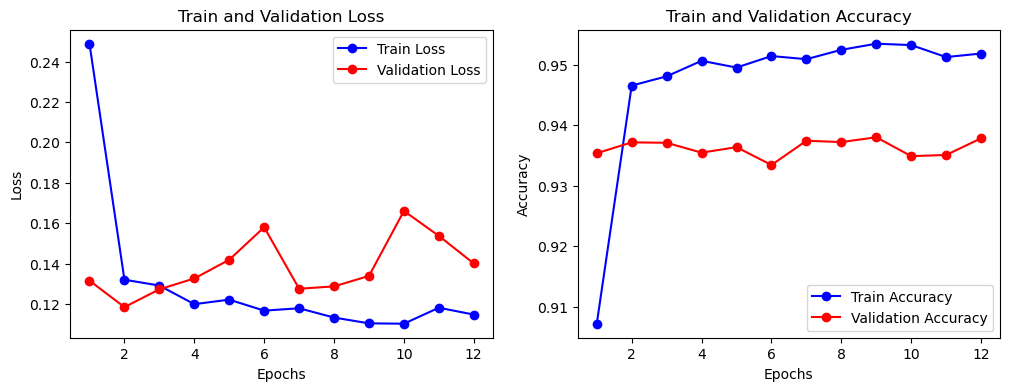

Model saved to BILSTM_model.pth


In [30]:
# BILSTM
# Training the model( you can skip this part to save your time, I have trained and saved the model.)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_corrects = 0
    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        epoch_train_corrects += torch.sum(preds == labels.data)

    epoch_train_loss /= len(train_loader)
    epoch_train_accuracy = epoch_train_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy.item())

    model.eval()
    epoch_val_loss = 0
    epoch_val_corrects = 0
    with torch.no_grad():
        for texts, labels in validation_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            epoch_val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss /= len(validation_loader)
    epoch_val_accuracy = epoch_val_corrects.double() / len(validation_loader.dataset)
    validation_losses.append(epoch_val_loss)
    validation_accuracies.append(epoch_val_accuracy.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

# Plot the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, validation_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the model
model_path = 'BILSTM_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1526
           1       0.99      0.91      0.95      1526
           2       0.93      1.00      0.96      1526
           3       0.97      0.93      0.95      1526
           4       0.93      0.92      0.93      1526
           5       0.93      1.00      0.96      1526

    accuracy                           0.95      9156
   macro avg       0.95      0.95      0.95      9156
weighted avg       0.95      0.95      0.95      9156

Confusion Matrix: 
 [[1453    7    0   35   30    1]
 [   2 1387  119    4    3   11]
 [   2    1 1521    0    2    0]
 [  30    4    2 1420   70    0]
 [   2    2    0    7 1406  109]
 [   0    0    0    0    1 1525]]


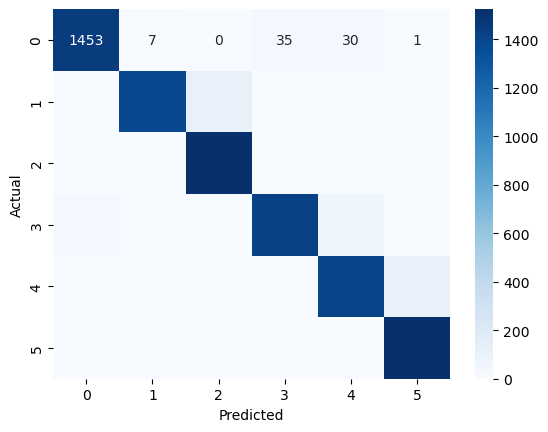

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model_path = 'BILSTM_model.pth'
model2.load_state_dict(torch.load(model_path, map_location=device))
model2.to(device)
model2.eval()

# Evaluate the model on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model2(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(output_dim)])
print("Test Set Performance:")
print(report)

# Print Confusion Matrix
conf = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix: \n",conf)

# Plot confusion matrix as a graph
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
# use the model to predict some sentences
import contextlib
import io

def predict_emotion(Text):

    # Temporarily redirect stdout to suppress print statements
    with io.StringIO() as buf, contextlib.redirect_stdout(buf):
        text = clean_text(Text)
    
    # Preprocess the text
    tokens = text.split()
    tokens = tokens[:35] + ['<PAD>'] * (35 - len(tokens))
    vectors = []
    for token in tokens:
        if token in word2vec:
            vectors.append(word2vec[token])
        else:
            vectors.append(np.zeros(embedding_dim))
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor([vectors], dtype=torch.float32).to(device)
    
    # Make prediction
    outputs = model2(input_tensor)
    _, preds = torch.max(outputs, 1)
    
    # Create a dictionary to map numeric labels to emotions
    label_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    
    # Convert numeric label to emotion
    predicted_emotion = label_to_emotion[preds.item()]
    
    # Print prediction
    print(f"The predicted emotion is: {predicted_emotion}")

print('input: I am happy.')
predict_emotion("I am happy.")
print('input: I feel happy.')
predict_emotion("I feel happy.")
print('input: I am sad.')
predict_emotion("I am sad.")
print('input: I feel sad.')
predict_emotion("I feel sad.")
print('input: I am surprised.')
predict_emotion("I am surprised.")
print('input: I feel surprised.')
predict_emotion("I feel surprised.")
print('input: I am angry.')
predict_emotion("I am angry.")
print('input: I feel angry.')
predict_emotion("I feel angry.")
print('input: I am scared.')
predict_emotion("I am scared.")
print('input: I feel scared.')
predict_emotion("I feel scared.")
print('input: I am sweet.')
predict_emotion("I am sweet.")
print('input: I feel sweet.')
predict_emotion("I feel sweet.")
predict_emotion(input("Please enter a text: "))

input: I am happy.
The predicted emotion is: joy
input: I feel happy.
The predicted emotion is: joy
input: I am sad.
The predicted emotion is: sadness
input: I feel sad.
The predicted emotion is: sadness
input: I am surprised.
The predicted emotion is: surprise
input: I feel surprised.
The predicted emotion is: surprise
input: I am angry.
The predicted emotion is: anger
input: I feel angry.
The predicted emotion is: anger
input: I am scared.
The predicted emotion is: fear
input: I feel scared.
The predicted emotion is: fear
input: I am sweet.
The predicted emotion is: joy
input: I feel sweet.
The predicted emotion is: love
Please enter a text: happy 
The predicted emotion is: joy


In [21]:
#Normal GRU model
class GRUModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = self.dropout(hidden[-1])
        out = self.fc(hidden)
        return out

# Hyperparameters
hidden_dim = 128
output_dim = len(train_df['label'].unique())
num_layers = 2
dropout = 0.1
learning_rate = 0.01
num_epochs = 10

# Initialize model, loss function, and optimizer
model = GRUModel(embedding_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 1119/1119 [01:32<00:00, 12.10it/s]


Epoch 1/10, Train Loss: 0.19519576402855462, Train Accuracy: 0.9311761254086679, Validation Loss: 0.19296532428817698, Validation Accuracy: 0.9276168997864734


100%|██████████| 1119/1119 [01:32<00:00, 12.13it/s]


Epoch 2/10, Train Loss: 0.16036853791731373, Train Accuracy: 0.9388325369547601, Validation Loss: 0.14503343243643277, Validation Accuracy: 0.931887430723831


100%|██████████| 1119/1119 [01:32<00:00, 12.04it/s]


Epoch 3/10, Train Loss: 0.1529733663719477, Train Accuracy: 0.9399502612680581, Validation Loss: 0.1662287618393547, Validation Accuracy: 0.933542861255728


100%|██████████| 1119/1119 [01:31<00:00, 12.19it/s]


Epoch 4/10, Train Loss: 0.1536879287899486, Train Accuracy: 0.9398664319445609, Validation Loss: 0.15250690031562436, Validation Accuracy: 0.9324872243948081


100%|██████████| 1119/1119 [01:31<00:00, 12.18it/s]


Epoch 5/10, Train Loss: 0.14858823201941182, Train Accuracy: 0.9405929527482046, Validation Loss: 0.17074611649757102, Validation Accuracy: 0.9298721239893476


100%|██████████| 1119/1119 [01:29<00:00, 12.54it/s]


Epoch 6/10, Train Loss: 0.14755812612336405, Train Accuracy: 0.9406069243021209, Validation Loss: 0.15364216495465283, Validation Accuracy: 0.9297761570019912


100%|██████████| 1119/1119 [01:27<00:00, 12.77it/s]


Epoch 7/10, Train Loss: 0.1502590614227017, Train Accuracy: 0.9399502612680581, Validation Loss: 0.16222061842152893, Validation Accuracy: 0.9344785393824524


100%|██████████| 1119/1119 [01:33<00:00, 11.96it/s]


Epoch 8/10, Train Loss: 0.1392227275158887, Train Accuracy: 0.943820381702853, Validation Loss: 0.13265674851943332, Validation Accuracy: 0.934646481610326


100%|██████████| 1119/1119 [01:33<00:00, 11.99it/s]


Epoch 9/10, Train Loss: 0.14558290999625761, Train Accuracy: 0.9411657864587699, Validation Loss: 0.20096789492991257, Validation Accuracy: 0.9237782202922195


100%|██████████| 1119/1119 [01:27<00:00, 12.85it/s]


Epoch 10/10, Train Loss: 0.14354684194042228, Train Accuracy: 0.942772515159136, Validation Loss: 0.1636050328872298, Validation Accuracy: 0.9320793646985437


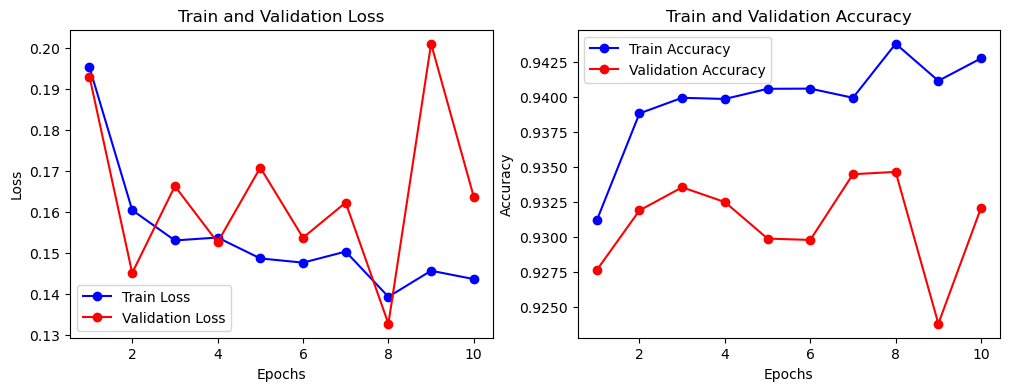

Model saved to UNIGRU_model.pth


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_corrects = 0
    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        epoch_train_corrects += torch.sum(preds == labels.data)

    epoch_train_loss /= len(train_loader)
    epoch_train_accuracy = epoch_train_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy.item())

    model.eval()
    epoch_val_loss = 0
    epoch_val_corrects = 0
    with torch.no_grad():
        for texts, labels in validation_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            epoch_val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss /= len(validation_loader)
    epoch_val_accuracy = epoch_val_corrects.double() / len(c.dataset)
    validation_losses.append(epoch_val_loss)
    validation_accuracies.append(epoch_val_accuracy.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

# Plot the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, validation_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the model
model_path = 'UNIGRU_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1526
           1       0.99      0.90      0.94      1526
           2       0.92      1.00      0.96      1526
           3       0.94      0.95      0.95      1526
           4       0.94      0.87      0.90      1526
           5       0.92      1.00      0.96      1526

    accuracy                           0.94      9156
   macro avg       0.95      0.94      0.94      9156
weighted avg       0.95      0.94      0.94      9156

Confusion Matrix: 
 [[1456    2    2   38   27    1]
 [   6 1368  126    5    8   13]
 [   2    2 1521    1    0    0]
 [  15    1    2 1454   53    1]
 [  32    7    1   50 1327  109]
 [   1    2    0    0    4 1519]]


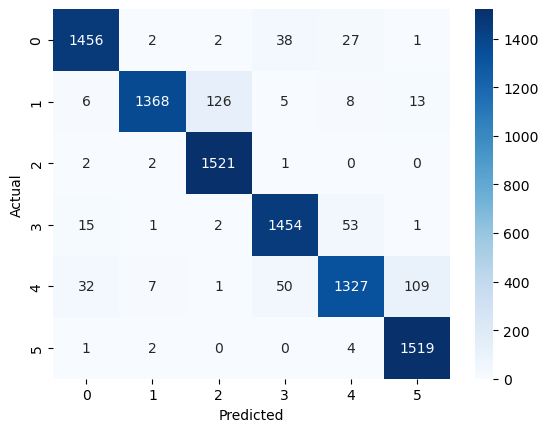

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model_path = 'UNIGRU_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Evaluate the model on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(output_dim)])
print("Test Set Performance:")
print(report)

# Print Confusion Matrix
conf = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix: \n",conf)

# Plot confusion matrix as a graph
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
# use the model to predict some sentences
import contextlib
import io

def predict_emotion(Text):

    # Temporarily redirect stdout to suppress print statements
    with io.StringIO() as buf, contextlib.redirect_stdout(buf):
        text = clean_text(Text)
    
    # Preprocess the text
    tokens = text.split()
    tokens = tokens[:35] + ['<PAD>'] * (35 - len(tokens))
    vectors = []
    for token in tokens:
        if token in word2vec:
            vectors.append(word2vec[token])
        else:
            vectors.append(np.zeros(embedding_dim))
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor([vectors], dtype=torch.float32).to(device)
    
    # Make prediction
    outputs = model(input_tensor)
    _, preds = torch.max(outputs, 1)
    
    # Create a dictionary to map numeric labels to emotions
    label_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    
    # Convert numeric label to emotion
    predicted_emotion = label_to_emotion[preds.item()]
    
    # Print prediction
    print(f"The predicted emotion is: {predicted_emotion}")

print('input: I am happy.')
predict_emotion("I am happy.")
print('input: I feel happy.')
predict_emotion("I feel happy.")
print('input: I am sad.')
predict_emotion("I am sad.")
print('input: I feel sad.')
predict_emotion("I feel sad.")
print('input: I am surprised.')
predict_emotion("I am surprised.")
print('input: I feel surprised.')
predict_emotion("I feel surprised.")
print('input: I am angry.')
predict_emotion("I am angry.")
print('input: I feel angry.')
predict_emotion("I feel angry.")
print('input: I am scared.')
predict_emotion("I am scared.")
print('input: I feel scared.')
predict_emotion("I feel scared.")
print('input: I am sweet.')
predict_emotion("I am sweet.")
print('input: I feel sweet.')
predict_emotion("I feel sweet.")
predict_emotion(input("Please enter a text: "))

input: I am happy.
The predicted emotion is: anger
input: I feel happy.
The predicted emotion is: joy
input: I am sad.
The predicted emotion is: fear
input: I feel sad.
The predicted emotion is: sadness
input: I am surprised.
The predicted emotion is: fear
input: I feel surprised.
The predicted emotion is: surprise
input: I am angry.
The predicted emotion is: anger
input: I feel angry.
The predicted emotion is: anger
input: I am scared.
The predicted emotion is: fear
input: I feel scared.
The predicted emotion is: fear
input: I am sweet.
The predicted emotion is: anger
input: I feel sweet.
The predicted emotion is: love


Please enter a text:  What a surprise


The predicted emotion is: fear


In [27]:
# Bidirectional GRU model
class BidirectionalGRUModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BidirectionalGRUModel, self).__init__()
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        out = self.fc(hidden)
        return out

In [36]:
# Hyperparameters
hidden_dim = 128
output_dim = len(train_df['label'].unique())
num_layers = 2
dropout = 0.1
learning_rate = 0.01
num_epochs = 20

# Initialize model, loss function, and optimizer
model = BidirectionalGRUModel(embedding_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BidirectionalGRUModel(
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

100%|██████████| 1119/1119 [01:39<00:00, 11.22it/s]


Epoch 1/20, Train Loss: 0.25654755067163487, Train Accuracy: 0.9067957638248526, Validation Loss: 0.17373956981446434, Validation Accuracy: 0.9328950840910727


100%|██████████| 1119/1119 [01:42<00:00, 10.90it/s]


Epoch 2/20, Train Loss: 0.1701297085695601, Train Accuracy: 0.9355911364461955, Validation Loss: 0.19028894672958763, Validation Accuracy: 0.9318154554833137


100%|██████████| 1119/1119 [01:51<00:00, 10.07it/s]


Epoch 3/20, Train Loss: 0.1780275147369962, Train Accuracy: 0.9336630620057562, Validation Loss: 0.17745363663530628, Validation Accuracy: 0.933278952040498


100%|██████████| 1119/1119 [01:44<00:00, 10.73it/s]


Epoch 4/20, Train Loss: 0.17299535121998422, Train Accuracy: 0.9340822086232431, Validation Loss: 0.17850431850739967, Validation Accuracy: 0.9321273481922219


100%|██████████| 1119/1119 [01:46<00:00, 10.53it/s]


Epoch 5/20, Train Loss: 0.16554607709593425, Train Accuracy: 0.9356051080001118, Validation Loss: 0.17654933079011578, Validation Accuracy: 0.9344545476356133


100%|██████████| 1119/1119 [01:50<00:00, 10.15it/s]


Epoch 6/20, Train Loss: 0.1593664727266129, Train Accuracy: 0.9377427557492944, Validation Loss: 0.16606374650742242, Validation Accuracy: 0.9338547539646361


100%|██████████| 1119/1119 [01:49<00:00, 10.23it/s]


Epoch 7/20, Train Loss: 0.1722555903932604, Train Accuracy: 0.9346690138877246, Validation Loss: 0.1931384195005121, Validation Accuracy: 0.9329430675847508


100%|██████████| 1119/1119 [01:46<00:00, 10.54it/s]


Epoch 8/20, Train Loss: 0.15429169509120425, Train Accuracy: 0.938273674798111, Validation Loss: 0.15343751172832232, Validation Accuracy: 0.933015042825268


100%|██████████| 1119/1119 [01:51<00:00, 10.04it/s]


Epoch 9/20, Train Loss: 0.16615510462942243, Train Accuracy: 0.9355771648922793, Validation Loss: 0.2017665487911232, Validation Accuracy: 0.9250977663683693


100%|██████████| 1119/1119 [01:50<00:00, 10.10it/s]


Epoch 10/20, Train Loss: 0.1776098879366294, Train Accuracy: 0.9332439153882695, Validation Loss: 0.15372890215424215, Validation Accuracy: 0.9352462752813032


100%|██████████| 1119/1119 [01:45<00:00, 10.64it/s]


Epoch 11/20, Train Loss: 0.15042693163763476, Train Accuracy: 0.9394053706653254, Validation Loss: 0.17348955640357924, Validation Accuracy: 0.932727141863199


100%|██████████| 1119/1119 [01:39<00:00, 11.23it/s]


Epoch 12/20, Train Loss: 0.19671379495328883, Train Accuracy: 0.927110403219046, Validation Loss: 0.22490423062724843, Validation Accuracy: 0.9227945586718168


100%|██████████| 1119/1119 [01:39<00:00, 11.24it/s]


Epoch 13/20, Train Loss: 0.20630493736139252, Train Accuracy: 0.9253779305334339, Validation Loss: 0.207405455199076, Validation Accuracy: 0.9193397471269883


100%|██████████| 1119/1119 [01:41<00:00, 10.99it/s]


Epoch 14/20, Train Loss: 0.1906844070023117, Train Accuracy: 0.9286053594880822, Validation Loss: 0.21080639836109855, Validation Accuracy: 0.918452052493942


100%|██████████| 1119/1119 [01:51<00:00, 10.07it/s]


Epoch 15/20, Train Loss: 0.2063379786355992, Train Accuracy: 0.9236594294017381, Validation Loss: 0.21909178248920871, Validation Accuracy: 0.9141095463160672


100%|██████████| 1119/1119 [01:51<00:00, 10.07it/s]


Epoch 16/20, Train Loss: 0.22253825568441732, Train Accuracy: 0.919956967613938, Validation Loss: 0.2313874798092671, Validation Accuracy: 0.9228185504186559


100%|██████████| 1119/1119 [01:51<00:00, 10.04it/s]


Epoch 17/20, Train Loss: 0.20048516058929805, Train Accuracy: 0.924707295945455, Validation Loss: 0.17961613755056097, Validation Accuracy: 0.9247378901657829


100%|██████████| 1119/1119 [01:51<00:00, 10.04it/s]


Epoch 18/20, Train Loss: 0.19603629729030544, Train Accuracy: 0.927361891189538, Validation Loss: 0.2271553413211111, Validation Accuracy: 0.917612341354574


100%|██████████| 1119/1119 [01:49<00:00, 10.23it/s]


Epoch 19/20, Train Loss: 0.19733056583682324, Train Accuracy: 0.9255735322882611, Validation Loss: 0.18993668294043217, Validation Accuracy: 0.9260574362419327


100%|██████████| 1119/1119 [01:50<00:00, 10.09it/s]


Epoch 20/20, Train Loss: 0.18831533623877597, Train Accuracy: 0.9288149327968256, Validation Loss: 0.18820039966669322, Validation Accuracy: 0.9259854610014154


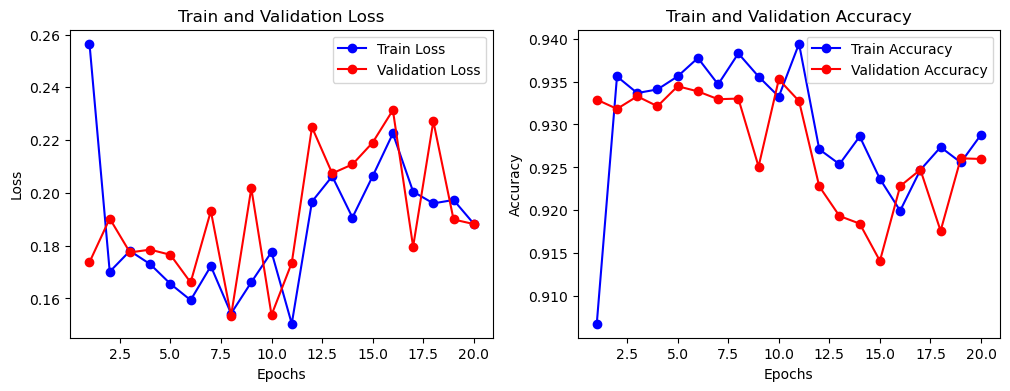

Model saved to BiGRU_model.pth


In [37]:
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_corrects = 0
    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        epoch_train_corrects += torch.sum(preds == labels.data)

    epoch_train_loss /= len(train_loader)
    epoch_train_accuracy = epoch_train_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy.item())

    model.eval()
    epoch_val_loss = 0
    epoch_val_corrects = 0
    with torch.no_grad():
        for texts, labels in validation_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            epoch_val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss /= len(validation_loader)
    epoch_val_accuracy = epoch_val_corrects.double() / len(validation_loader.dataset)
    validation_losses.append(epoch_val_loss)
    validation_accuracies.append(epoch_val_accuracy.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

# Plot the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, validation_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the model
model_path = 'BiGRU_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1526
           1       0.99      0.88      0.93      1526
           2       0.92      1.00      0.95      1526
           3       0.95      0.94      0.94      1526
           4       0.92      0.87      0.90      1526
           5       0.93      0.98      0.95      1526

    accuracy                           0.94      9156
   macro avg       0.94      0.94      0.94      9156
weighted avg       0.94      0.94      0.94      9156

Confusion Matrix: 
 [[1463    5    4   35   18    1]
 [  16 1349  132   15    3   11]
 [   3    1 1519    2    0    1]
 [  31    3    1 1429   62    0]
 [  61    4    2   22 1333  104]
 [   0    0    1    1   29 1495]]


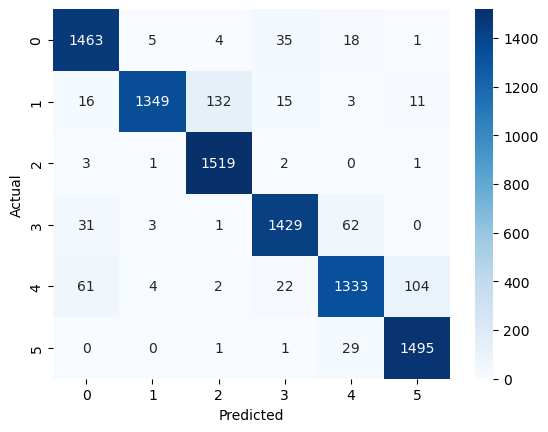

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model_path = 'BiGRU_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Evaluate the model on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(output_dim)])
print("Test Set Performance:")
print(report)

# Print Confusion Matrix
conf = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix: \n",conf)

# Plot confusion matrix as a graph
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# use the model to predict some sentences
import contextlib
import io

def predict_emotion(Text):

    # Temporarily redirect stdout to suppress print statements
    with io.StringIO() as buf, contextlib.redirect_stdout(buf):
        text = clean_text(Text)
    
    # Preprocess the text
    tokens = text.split()
    tokens = tokens[:35] + ['<PAD>'] * (35 - len(tokens))
    vectors = []
    for token in tokens:
        if token in word2vec:
            vectors.append(word2vec[token])
        else:
            vectors.append(np.zeros(embedding_dim))
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor([vectors], dtype=torch.float32).to(device)
    
    # Make prediction
    outputs = model(input_tensor)
    _, preds = torch.max(outputs, 1)
    
    # Create a dictionary to map numeric labels to emotions
    label_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    
    # Convert numeric label to emotion
    predicted_emotion = label_to_emotion[preds.item()]
    
    # Print prediction
    print(f"The predicted emotion is: {predicted_emotion}")

print('input: I am happy.')
predict_emotion("I am happy.")
print('input: I feel happy.')
predict_emotion("I feel happy.")
print('input: I am sad.')
predict_emotion("I am sad.")
print('input: I feel sad.')
predict_emotion("I feel sad.")
print('input: I am surprised.')
predict_emotion("I am surprised.")
print('input: I feel surprised.')
predict_emotion("I feel surprised.")
print('input: I am angry.')
predict_emotion("I am angry.")
print('input: I feel angry.')
predict_emotion("I feel angry.")
print('input: I am scared.')
predict_emotion("I am scared.")
print('input: I feel scared.')
predict_emotion("I feel scared.")
print('input: I am sweet.')
predict_emotion("I am sweet.")
print('input: I feel sweet.')
predict_emotion("I feel sweet.")
predict_emotion(input("Please enter a text: "))

input: I am happy.
The predicted emotion is: joy
input: I feel happy.
The predicted emotion is: joy
input: I am sad.
The predicted emotion is: sadness
input: I feel sad.
The predicted emotion is: sadness
input: I am surprised.
The predicted emotion is: surprise
input: I feel surprised.
The predicted emotion is: surprise
input: I am angry.
The predicted emotion is: anger
input: I feel angry.
The predicted emotion is: anger
input: I am scared.
The predicted emotion is: fear
input: I feel scared.
The predicted emotion is: fear
input: I am sweet.
The predicted emotion is: love
input: I feel sweet.
The predicted emotion is: love


Please enter a text:  surprising


The predicted emotion is: surprise
